In [42]:
from dotenv import load_dotenv
import os
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
from typing import TypedDict, Sequence, Annotated
import operator
from langchain_core.messages import BaseMessage
from langgraph.graph import StateGraph, START,END


In [43]:
load_dotenv()

True

In [44]:
llm = ChatGroq(model_name = "deepseek-r1-distill-llama-70b")
llm.invoke("What is the capital of France?")

AIMessage(content='<think>\n\n</think>\n\nThe capital of France is Paris.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 10, 'total_tokens': 22, 'completion_time': 0.060028312, 'prompt_time': 0.000215678, 'queue_time': 0.2176101, 'total_time': 0.06024399}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--41380730-1cec-4a67-aefb-df8193a60d8f-0', usage_metadata={'input_tokens': 10, 'output_tokens': 12, 'total_tokens': 22})

Implementing Human in Loop from scratch

In [45]:
@tool
def multiply(x: int, y: int) -> int:
    """Multiplies two numbers."""
    return x * y

In [46]:
@tool
def search(query: str) -> TavilySearchResults:
    """Searches the web for a query and return the results"""
    tavily_search = TavilySearchResults()
    result = tavily_search.invoke(query)
    
    return f"Result for {query} in \n{result}"

In [47]:
tools = [multiply, search]
llm_with_tools = llm.bind_tools(tools)

In [48]:
tool_mapping={tool.name:tool for tool in tools}

In [49]:
class AgentState(TypedDict):
    """State of the agent."""
    messages: Annotated[Sequence[BaseMessage],operator.add]
    
def invoke_model(state:AgentState):
    messages=state["messages"]
    question=messages[-1]
    response=llm_with_tools.invoke(question)
    return {"messages":[response]}
    
def router(state:AgentState):
    tool_calls=state["messages"][-1].tool_calls
    if len(tool_calls)>0:
        return "tool" #key name
    else:
        return "end" #key name
def invoke_tool(state:AgentState):
    tool_details=state["messages"][-1].tool_calls
    
    if tool_details is None:
        return Exception("No tool calls found in the last message.")
    
    print(f"Seleted tool: {tool_details[0]['name']}")
    
    if tool_details[0]["name"]=="search":
        response=input(prompt=f"[yes/no] do you want to continue with this expensive web search")
        if response.lower()=="no":
            print("web search discarded by the user. exiting gracefully")
            raise Exception("Web search discarded by the user.")
            
    
    response=tool_mapping[tool_details[0]["name"]].invoke(tool_details[0]["args"])
    return {"messages":[response]}

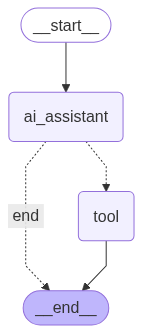

In [51]:
graph=StateGraph(AgentState)

graph.add_node("ai_assistant", invoke_model)
graph.add_node("tool", invoke_tool)
graph.add_conditional_edges("ai_assistant", router,{"tool":"tool","end":END})
graph.add_edge("tool", END)
graph.set_entry_point("ai_assistant")

app=graph.compile()                           
app 

Inbuilt Human In Loop in LangGraph